# Exercise 13 (1) - Hamiltonian & Lagrangian Neural Networks

### Task

Implement and train a Hamiltonian neural network

* Implement the cost computation in the training loop
* Perform a training with the Hamiltonian neural network and compare it to the conventional neural network (`exercise13_3.ipynb`) and the Lagrangian neural network (`exercise13_2.ipynb`)

In [1]:
import torch
import numpy as np
from torch.autograd import grad
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(2)

## User settings

sampling parameters

In [3]:
dx0dt = 1
k = 10
m = 1

tmaxTraining = 1.5
numberOfTrainingSamples = 50
tmaxValidation = 9
numberOfValidationSamples = 300

neural network architecture

In [4]:
neurons = 50
layers = 2

hyperparameters

In [5]:
lr = 1e-3
epochs = 5000

## Utilities

neural network

In [6]:
class FNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize, neurons, layers):
        super().__init__()

        self.layers = layers

        self.linear1 = torch.nn.Linear(inputSize, neurons)
        self.linear2 = torch.nn.ModuleList()
        for i in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))
        self.linear3 = torch.nn.Linear(neurons, outputSize)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        y = self.activation(self.linear1(x))
        for i in range(self.layers):
            y = self.activation(self.linear2[i](y))
        y = self.linear3(y)
        return y

derivative function

In [7]:
def getDerivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""

    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

## Data generation
analytical solution

In [8]:
omega = np.sqrt(k / m)

A = dx0dt / omega
phi = 0
x = lambda t: A * np.sin(omega * t + phi)
dxdt = lambda t: omega * A * np.cos(omega * t + phi)
ddxdtt = lambda t: - omega ** 2 * A * np.sin(omega * t + phi)

training data

In [9]:
tTraining = np.linspace(0, tmaxTraining, numberOfTrainingSamples)
# TODO add noise
trainingData = torch.vstack((torch.from_numpy(x(tTraining)),
                             m * torch.from_numpy(dxdt(tTraining)),
                             m * torch.from_numpy(ddxdtt(tTraining)))).to(torch.float32).T

validation data

In [10]:
tValidation = np.linspace(0, tmaxValidation, numberOfValidationSamples)
validationData = torch.vstack((torch.from_numpy(x(tValidation)),
                               m * torch.from_numpy(dxdt(tValidation)),
                               m * torch.from_numpy(ddxdtt(tValidation)))).to(torch.float32).T

model input

In [11]:
modelInputTraining = trainingData[:, :2]
modelInputTraining.requires_grad = True

modelInputValidation = validationData[:, :2]
modelInputValidation.requires_grad = True

## Hamiltonian model training
pre-processing

In [13]:
model = FNN(2, 1, neurons, layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
costHistory = np.zeros(epochs)

training loop

In [14]:
for epoch in range(epochs):
    optimizer.zero_grad()

    HPred = model(modelInputTraining)

    dHPreddx = getDerivative(HPred, modelInputTraining, 1)
    cost = torch.mean((dHPreddx[:, 0] + trainingData[:, 2]) ** 2 + (dHPreddx[:, 1] - trainingData[:, 1] / m) ** 2)
    costHistory[epoch] = cost.detach()

    cost.backward()

    optimizer.step()

    if epoch % 50 == 0:
        print("Epoch: {}/{}\t\tCost function: {:.3E}".format(epoch, epochs, cost.detach()))

Epoch: 0/5000		Cost function: 5.473E+00
Epoch: 50/5000		Cost function: 2.366E+00
Epoch: 100/5000		Cost function: 1.985E-02
Epoch: 150/5000		Cost function: 2.875E-03
Epoch: 200/5000		Cost function: 1.311E-03
Epoch: 250/5000		Cost function: 7.615E-04
Epoch: 300/5000		Cost function: 4.963E-04
Epoch: 350/5000		Cost function: 3.490E-04
Epoch: 400/5000		Cost function: 2.657E-04
Epoch: 450/5000		Cost function: 2.163E-04
Epoch: 500/5000		Cost function: 1.837E-04
Epoch: 550/5000		Cost function: 1.592E-04
Epoch: 600/5000		Cost function: 1.388E-04
Epoch: 650/5000		Cost function: 1.212E-04
Epoch: 700/5000		Cost function: 1.058E-04
Epoch: 750/5000		Cost function: 9.225E-05
Epoch: 800/5000		Cost function: 8.048E-05
Epoch: 850/5000		Cost function: 7.031E-05
Epoch: 900/5000		Cost function: 6.157E-05
Epoch: 950/5000		Cost function: 5.407E-05
Epoch: 1000/5000		Cost function: 4.764E-05
Epoch: 1050/5000		Cost function: 4.210E-05
Epoch: 1100/5000		Cost function: 3.731E-05
Epoch: 1150/5000		Cost function: 3

## Post-processing

In [15]:
numberOfTimeSteps = 10000  # for the forward Euler scheme

forward Euler scheme

In [16]:
tPrediction = np.linspace(0, tmaxValidation, numberOfTimeSteps + 1)
dt = tmaxValidation / numberOfTimeSteps
xPrediction = torch.zeros((2, numberOfTimeSteps + 1), requires_grad=False)
xPrediction[:, 0] = validationData[0, :2] # initial conditions

HPredictions = np.zeros(numberOfTimeSteps)
HLabel = 0.5 * m * validationData[:, 1] ** 2 + 0.5 * k * validationData[:, 0] ** 2

for i in range(numberOfTimeSteps):
    currentx = xPrediction[:, i].unsqueeze(0).detach()
    currentx.requires_grad = True
    HPred = model(currentx)
    HPredictions[i] = HPred[0].detach()
    dHPreddx = getDerivative(HPred, currentx, 1)
    xPrediction[:, i + 1] = (xPrediction[:, i] + dt * torch.tensor([dHPreddx[0, 1], -dHPreddx[0, 0]])).detach()

transient response

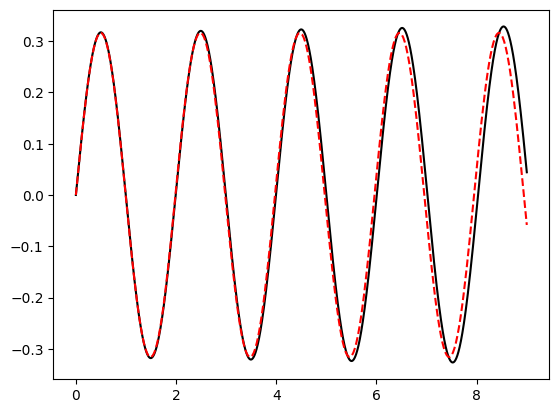

In [17]:
fig, ax = plt.subplots()
ax.plot(tPrediction, xPrediction[0, :], 'k')
ax.plot(tValidation, validationData[:, 0], 'r--')
plt.show()

position-momentum space

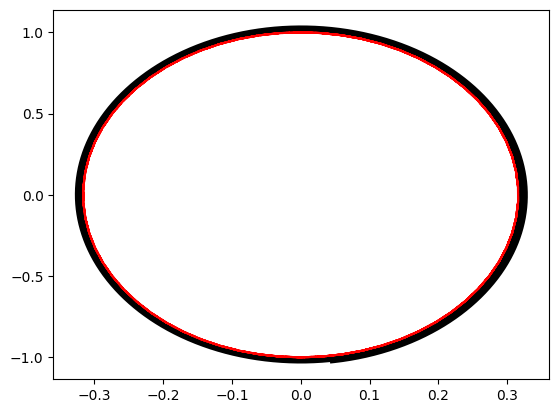

In [18]:
fig, ax = plt.subplots()
ax.plot(xPrediction[0, :], xPrediction[1, :], 'k')
ax.plot(validationData[:, 0], validationData[:, 1], 'r--')
plt.show()

energy evolution

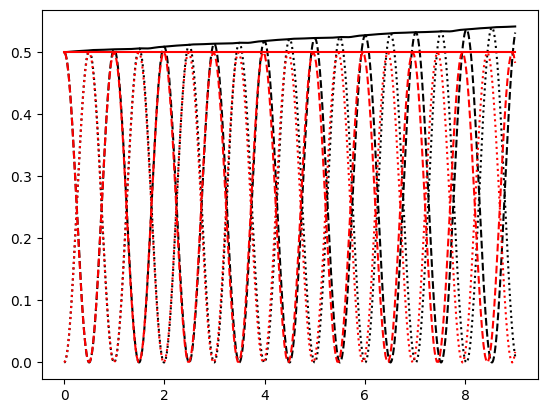

In [19]:
fig, ax = plt.subplots()
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2, 'k--')
ax.plot(tPrediction, 0.5 * k * xPrediction[0, :] ** 2, 'k:')
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2 + 0.5 * k * xPrediction[0, :] ** 2, 'k')

ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2, 'r--')
ax.plot(tValidation, 0.5 * k * validationData[:, 0] ** 2, 'r:')
ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2 + 0.5 * k * validationData[:, 0] ** 2, 'r')
plt.show()

Hamiltonian prediction

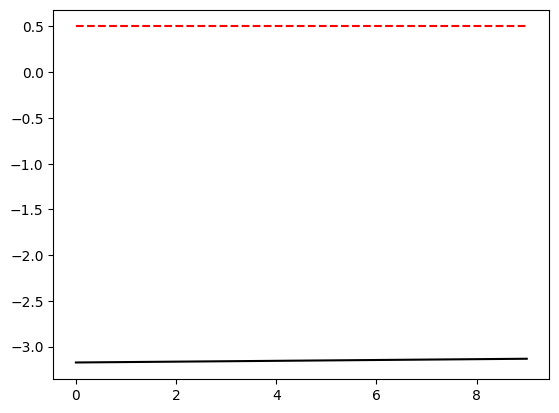

In [20]:
fig, ax = plt.subplots()
ax.plot(tPrediction[:-1], HPredictions, 'k')
ax.plot(tValidation, HLabel, 'r--')
plt.show()

learning history

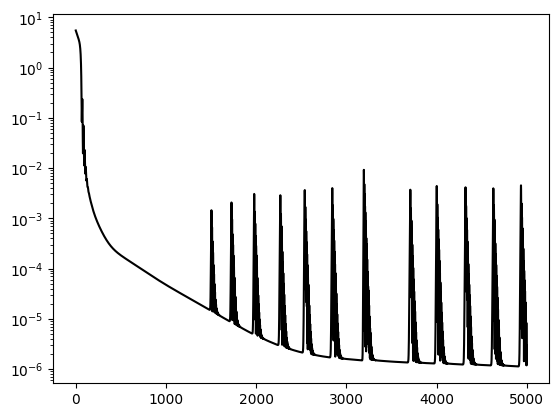

In [21]:
fig, ax = plt.subplots()
ax.plot(costHistory, 'k')
ax.set_yscale('log')
plt.show()